# Modeling: Sprint 2

**Table of Contents**<a id='toc0_'></a>  

- [Libraries](#toc_1)  
- [Train/Test Split](#toc1_)    
  - [Intialize DF for evaluation meteric](#toc1_1_)    
- [Forecasting with Regression: Baseline Models](#toc2_)    
    - [Average/Mean Model](#toc2_1_)    
    - [Linear Regression Model with One Feature](#toc2_2_)    
    - [Linear Regression Model with One-Hot Encoding Feature](#toc2_3_)    
    - [Regression Model Summary](#toc2_4_)    
    - [Linear Regression Model with Dataset Features](#toc2_5_)    
  - [Forecasting with ARIMA Model](#toc3_)    
  - [Next Steps](#toc4_)    
  

# Libraries

In [100]:
# Standard imports
import numpy as np
import pandas as pd
import itertools
import warnings
from datetime import datetime
from ipywidgets import interactive
import ipywidgets as widgets

# Loading sklearn functionality from prior lessons
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Important functionality for this lesson
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

#Statistical tools for model building etc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
warnings.filterwarnings('ignore')
#import plotly.io as pio
#pio.renderers.default = "notebook_connected"  # for Jupyter
#pio.renderers.default = "png"  # forces static image output
#import kaleido

In [101]:
# Global plotting parameters
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams["axes.grid"] = True

# Brand colors dictionary
brand_colors = {
    "Denim": "#1358DB",
    "Supernova": "#FFCF00",
    # "Black": "#000000",
    # "Dark Blue": "#101D42",
    # "White": "#FFFFFF",
    "Dark Gray": "#6F6F6F",
    # "Light Gray 1": "#F6F6F4",
    "Light Gray 2": "#ADBDCC"
}

# Create a matplotlib colormap
brand_cmap = plt.cm.colors.ListedColormap(list(brand_colors.values()))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=brand_colors.values())

"""
Note: Suppressing warnings is generally not recommended. 
Warnings are being ignored in this notebook to prevent unnecessary clutter
and improve readability while working through the lesson
"""
filterwarnings(action='ignore')

# Train/Test Split

In order to properly evaluate our models, we need to isolate our Train and Test set. In traditional machine learning  modeling, we generally take random samples of data points and have them randomly assigned to the corresponding sets. **This is not possible in Time Series because there is an order to time that we need to preserve**. In order to keep the sequential order of our data, we generally take a proportion of the most recent data points, and assign them to the Test set. We use the remainder points as our Train set.

First lets start by loading our data, we will use the daily average sampled data that we created in the previous notebook for preprocessing

In [102]:

power_df_monthly = pd.read_csv(r"C:\Users\karni\OneDrive\Desktop\GitHub\BrainStation_CapstoneProject\data\power_weather_monthly.csv",index_col='DateTime')

power_df_monthly.head()

,Energy Consumed by Household (Watt-hour),"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,,
2006-12-01,31.688252,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,25.767232,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,23.351392,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,21.977117,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,14.853149,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [103]:
power_df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 2006-12-01 to 2010-11-01
Data columns (total 20 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Energy Consumed by Household (Watt-hour)                                     48 non-null     float64
 1   Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)  48 non-null     float64
 2   Reactive Energy Consumed by Household (Watt-hour)                            48 non-null     float64
 3   Voltage (volts)                                                              48 non-null     float64
 4   Global_intensity (amperes)                                                   48 non-null     float64
 5   Sub_metering_1 (watt-hours of active energy)                                 48 non-null     float64
 6   Sub_metering_2 (watt-hours of ac

In [104]:
# Time Series Split (test set = most recent 25% of data)

# finding the row number equivalent to 75% of the data
cutoff = int(len(power_df_monthly) * 0.75)
cutoff_date = power_df_monthly.index.sort_values()[cutoff]
print(f"Cutoff at: {cutoff_date}")

# extract train and test indices
dates_train = power_df_monthly.index[power_df_monthly.index <= cutoff_date]
date_train = pd.to_datetime(dates_train) # changing to time stamp
dates_test = power_df_monthly.index[power_df_monthly.index > cutoff_date]
date_test = pd.to_datetime(dates_test) # changing to time stamp

# extract dimensions
print(f"Training Set: {len(dates_train)} days")
print(f"Test Set: {len(dates_test)} days")

Cutoff at: 2009-12-01
Training Set: 37 days
Test Set: 11 days


In [105]:
# Extracting the target variable Energy Consumed by Household (Watt-hour)
y_train = power_df_monthly['Energy Consumed by Household (Watt-hour)'].loc[dates_train]
y_test = power_df_monthly['Energy Consumed by Household (Watt-hour)'].loc[dates_test]

## Initialize a dataframe for storing model evaluation metric results


In [106]:
summary_df = pd.DataFrame(columns=["Train_MAE", "Test_MAE", "Train_MAPE", "Test_MAPE"])

# <a id='toc5_'></a>Forecasting with Regression: Baseline Models [&#8593;](#toc0_)



In this section I will build 3 different models, starting from a naive simple average model, to a multiple linear regression model with one-hot encoded variables to represent the different months

At every iteration I will fit the model, visualize it against the original data and evaluate the predictions. I will not apply any regularization for now, we will use Lasso, Ridge, in Sprint 3 for of regression model.


Here is an overview of the models that I  will build:

1. **Average Model:** $y = mean(y)$
  
2. **Linear Model with One Feature:** $y = \beta_0 + \beta_1\text{DaysFromStart}$

3. **Linear Model with Dummy Variables:** $y = \beta_0 + \beta_1\text{DaysFromStart} + \beta_2\text{January} + \beta_3\text{February} + .... + \beta_{13}\text{December}$



As we go through the model building process we will use the following table to keep track of our model performance metrics:

## Average Model

We will start with a  model of simply guessing the mean of the data. We do not expect this to perform well, however it serves as a good starting point to extract some baseline evaluation metrics that we will try to improve further down.

In [107]:
# Predict

train_mean = y_train.mean()

training_size = len(dates_train)
test_size = len(dates_test)

mean_pred_train = np.full((training_size, 1), train_mean)
mean_pred_test = np.full((test_size, 1), train_mean) 

In [108]:
# Drop NaNs from target and predictions for fair comparison
train_mask = ~y_train.isna()
test_mask = ~y_test.isna()

summary_df.loc['Mean'] = [
    mean_absolute_error(
        y_train[train_mask],
        mean_pred_train.flatten()[train_mask.values]
    ),
    mean_absolute_error(
        y_test[test_mask],
        mean_pred_test.flatten()[test_mask.values]
    ),
    mean_absolute_percentage_error(
        y_train[train_mask],
        mean_pred_train.flatten()[train_mask.values]
    ),
    mean_absolute_percentage_error(
        y_test[test_mask],
        mean_pred_test.flatten()[test_mask.values]
    )
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347,3.101882,0.292217,0.215832


In [109]:
import plotly.graph_objs as go

fig = go.Figure()

# Original time series
fig.add_trace(go.Scatter(
    x=power_df_monthly.index,
    y=power_df_monthly['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=mean_pred_train.flatten(),
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=mean_pred_test.flatten(),
    mode='lines',
    name='test',
    line=dict(color='green', dash='dash')
))

# Set x-axis ticks for better readability
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
fig.update_layout(
    title='Average Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=power_df_monthly.index[::step],
        ticktext=labels[::step],
        tickangle=45
    ),
    width=900,
    height=400
)

#fig.show()

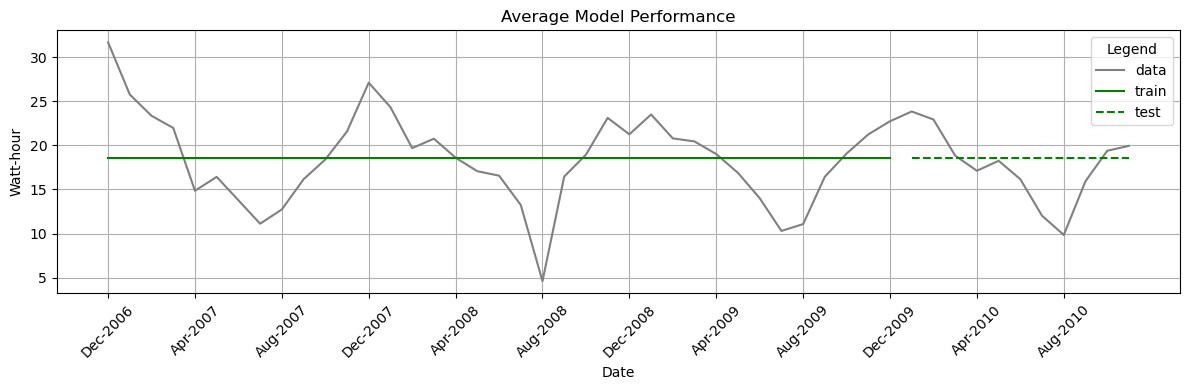

In [110]:
plt.figure()

# Original time series
plt.plot(power_df_monthly.index, power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label='data')

# Train predictions
plt.plot(dates_train, mean_pred_train.flatten(), color='green', label='train')

# Test predictions
plt.plot(dates_test, mean_pred_test.flatten(), color='green', linestyle='--', label='test')

plt.title('Average Model Performance')
plt.ylabel('Watt-hour')
plt.xlabel('Date')
plt.legend(title='Legend')

# Format x-axis as month-year and reduce number of ticks
locs = plt.gca().get_xticks()
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
plt.xticks(ticks=range(0, len(labels), step), labels=labels[::step], rotation=45)

plt.tight_layout()
plt.show()


## Linear Regression Model with One Feature

We will now proceed by adding our first freature: `days_from_start` 

In [111]:
first_day = power_df_monthly.index.min() # We get a string here
first_day = pd.to_datetime(first_day) # cahnging to time stamp
print(first_day)

2006-12-01 00:00:00


In [112]:
# Feature Engineering

# Ensure first_day is a Timestamp
first_day = pd.to_datetime(power_df_monthly.index.min())

# Ensure dates_train and dates_test are DatetimeIndex
dates_train_dt = pd.to_datetime(dates_train)
dates_test_dt = pd.to_datetime(dates_test)

# Create a numerical X feature that encodes the days from the start of the data
X_train = pd.DataFrame({"days_from_start": (dates_train_dt - first_day).days}, index=dates_train)
X_test = pd.DataFrame({"days_from_start": (dates_test_dt - first_day).days}, index=dates_test)

X_train.head()

,days_from_start
DateTime,
2006-12-01,0
2007-01-01,31
2007-02-01,62
2007-03-01,90
2007-04-01,121


In [113]:
y_train.head()

DateTime
2006-12-01    31.688252
2007-01-01    25.767232
2007-02-01    23.351392
2007-03-01    21.977117
2007-04-01    14.853149
Name: Energy Consumed by Household (Watt-hour), dtype: float64

In [114]:
# Fit
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict
linreg_pred_train = linreg.predict(X_train)
linreg_pred_test = linreg.predict(X_test)

In [115]:
# Evaluate

summary_df.loc['linreg'] = [
    mean_absolute_error(y_train, linreg_pred_train),
    mean_absolute_error(y_test, linreg_pred_test),
    mean_absolute_percentage_error(y_train, linreg_pred_train),
    mean_absolute_percentage_error(y_test, linreg_pred_test)
]


fig = go.Figure()

# Original time series
fig.add_trace(go.Scatter(
    x=power_df_monthly.index,
    y=power_df_monthly['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=linreg_pred_train,
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=linreg_pred_test,
    mode='lines',
    name='test',
    line=dict(color='green', dash='dash')
))

# Set x-axis ticks for better readability
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
fig.update_layout(
    title='Linear Regression Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=power_df_monthly.index[::step],
        ticktext=labels[::step],
        tickangle=45
    ),
    width=900,
    height=400
)

fig.show()


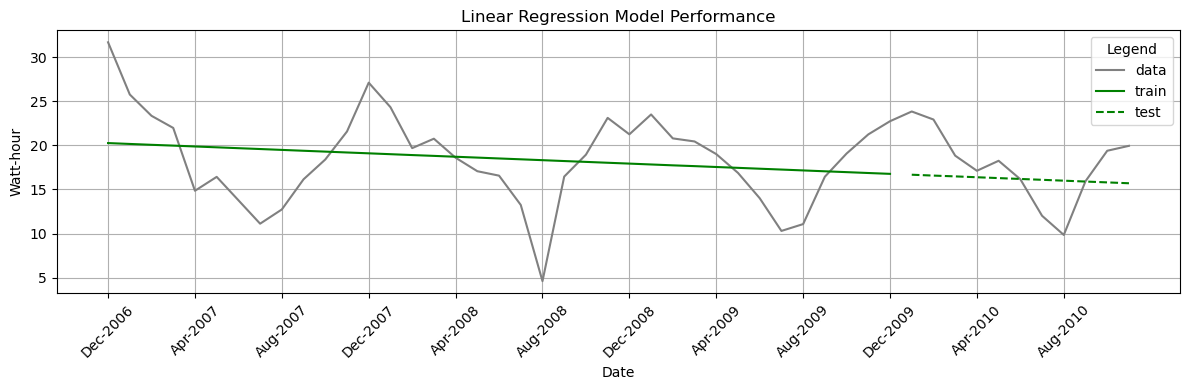

In [116]:
plt.figure(figsize=(12, 4))

# Original time series
plt.plot(power_df_monthly.index, power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label='data')

# Train predictions
plt.plot(dates_train, linreg_pred_train, color='green', label='train')

# Test predictions
plt.plot(dates_test, linreg_pred_test, color='green', linestyle='--', label='test')

plt.title('Linear Regression Model Performance')
plt.ylabel('Watt-hour')
plt.xlabel('Date')
plt.legend(title='Legend')

# Format x-axis as month-year and reduce number of ticks
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
plt.xticks(ticks=range(0, len(labels), step), labels=labels[::step], rotation=45)

plt.tight_layout()
plt.show()


In [117]:
summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347,3.101882,0.292217,0.215832
linreg,4.077902,3.336767,0.294629,0.201769


This looks slightly better  in  our visual intuition.  As you might expect, our model captures the overal trend of the data as a straight line with an downward slope.  Our evaluation metrics indicate that our model has an overall error of 4.07	Watt-hour on average (MAE) for training data, but a lower error rate of 3.33 Watt-hour for test data.  



## <a id='toc5_2_'></a>Linear Regression with One-Hot Encoding Feature [&#8593;](#toc0_)

In [118]:
# Feature Engineering for One-Hot Encoding

# instantiate encoder
ohe = OneHotEncoder(sparse_output=False, dtype=int)

# extract month names from index (convert to datetime if needed)
months_train = pd.to_datetime(X_train.index).month_name().values.reshape(-1, 1)
months_test = pd.to_datetime(X_test.index).month_name().values.reshape(-1, 1)

# fit on train set, transform train and test
ohe_months_train = ohe.fit_transform(months_train)
ohe_months_test = ohe.transform(months_test)

# convert data back into a dataframe
ohe_train_df = pd.DataFrame(ohe_months_train, columns=ohe.get_feature_names_out(), index=X_train.index)
ohe_test_df = pd.DataFrame(ohe_months_test, columns=ohe.get_feature_names_out(), index=X_test.index)

# concatenate days_from_start and month dummies
X_train_ohe = pd.concat([X_train, ohe_train_df], axis=1)
X_test_ohe = pd.concat([X_test, ohe_test_df], axis=1)


In [119]:
X_train_ohe.head()

,days_from_start,x0_April,x0_August,x0_December,x0_February,x0_January,x0_July,x0_June,x0_March,x0_May,x0_November,x0_October,x0_September
DateTime,,,,,,,,,,,,,
2006-12-01,0,0,0,1,0,0,0,0,0,0,0,0,0
2007-01-01,31,0,0,0,0,1,0,0,0,0,0,0,0
2007-02-01,62,0,0,0,1,0,0,0,0,0,0,0,0
2007-03-01,90,0,0,0,0,0,0,0,1,0,0,0,0
2007-04-01,121,1,0,0,0,0,0,0,0,0,0,0,0


In [120]:
X_train_ohe.shape

(37, 13)

In [121]:
# Fit
linreg_ohe = LinearRegression()
linreg_ohe.fit(X_train_ohe, y_train)

# Predict
ohe_pred_train = linreg_ohe.predict(X_train_ohe)
ohe_pred_test = linreg_ohe.predict(X_test_ohe)

In [122]:
# Evaluate

summary_df.loc['linreg_ohe'] = [
    mean_absolute_error(y_train, ohe_pred_train),
    mean_absolute_error(y_test, ohe_pred_test),
    mean_absolute_percentage_error(y_train, ohe_pred_train),
    mean_absolute_percentage_error(y_test, ohe_pred_test)
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347,3.101882,0.292217,0.215832
linreg,4.077902,3.336767,0.294629,0.201769
linreg_ohe,1.315639,1.717609,0.095819,0.104766


In [123]:
# Original time series
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=power_df_monthly.index,
    y=power_df_monthly['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=ohe_pred_train,
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=ohe_pred_test,
    mode='lines',
    name='test',
    line=dict(color='green', dash='dash')
))

fig.update_layout(
    title='Linear Regression with One Hot Encoding Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend'
)

fig.show()

We can see that our model is now  able to capture the cyclic nature of  the energy consumption data, which was not possible with the simple linear regression model that only used the days from the start of the data as a feature. The one-hot encoding of the month allows the model to learn seasonal patterns in energy consumption, leading to improved predictions.

In [124]:
summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347,3.101882,0.292217,0.215832
linreg,4.077902,3.336767,0.294629,0.201769
linreg_ohe,1.315639,1.717609,0.095819,0.104766


When predicting on unseen data, our model was on average ~1.7 Watt hour away from the true monthly Energy Consumption. MAPE provides a relative measure of error by dividing the errors by the original values of the time series, and shows that our model is on average ~10% away when making predictions, which is better than the previous models of ~20%.

## <a id='toc5_4_'></a>Regression Model Summary [&#8593;](#toc0_)

Overall we can see that the third model (linear regression with one hot encoded month variables) has performed the best out of the 3. This is clear both by visual inspection, and by looking at the evaluation metrics below.

Focusing on the test set for the fourth model:

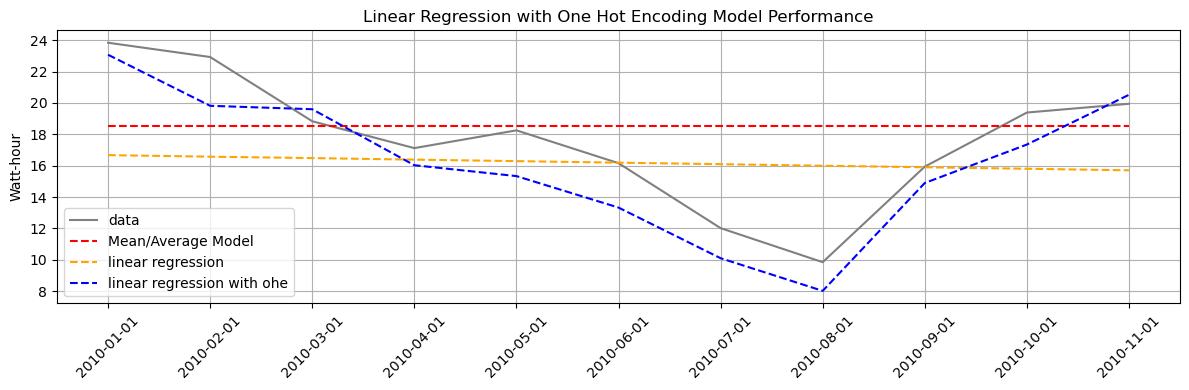

In [125]:
plt.figure()


# Original time series (test set)
plt.plot(y_test, color='grey', label="data")

# Model performance
plt.plot(dates_test, mean_pred_test, color='red', ls="--", label="Mean/Average Model")
plt.plot(dates_test, linreg_pred_test, color='orange', ls="--", label="linear regression")
plt.plot(dates_test, ohe_pred_test, color='blue', ls="--", label="linear regression with ohe")

plt.ylabel("Watt-hour")
plt.title("Linear Regression with One Hot Encoding Model Performance")
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Lets  now create a model that takes into account the original features of the dataset, such as temperature, humidity, and wind speed, to predict the energy consumption of the household. This will allow us to see if we can improve our model's performance by incorporating these additional features.


4. **Linear Model with Features:** $y = \beta_0 + \beta_1\text{X1} + \beta_2\text{X2} + \beta_3\text{X3} + .... + \beta_{19}\text{X19}$
  
  where, X represents the features we have in the dataset for power df

## Linear Regression model with Dataset Features

We will be using a linear regression  with data set model  to forecast the Energy Consumption 

In [126]:
power_df_monthly.head()

,Energy Consumed by Household (Watt-hour),"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,,
2006-12-01,31.688252,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,25.767232,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,23.351392,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,21.977117,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,14.853149,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [127]:
# Pull out the X and y
X = power_df_monthly.drop('Energy Consumed by Household (Watt-hour)', axis=1)
y = power_df_monthly["Energy Consumed by Household (Watt-hour)"].copy()

In [128]:
X.head()

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,
2006-12-01,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [129]:
y.head()

DateTime
2006-12-01    31.688252
2007-01-01    25.767232
2007-02-01    23.351392
2007-03-01    21.977117
2007-04-01    14.853149
Name: Energy Consumed by Household (Watt-hour), dtype: float64

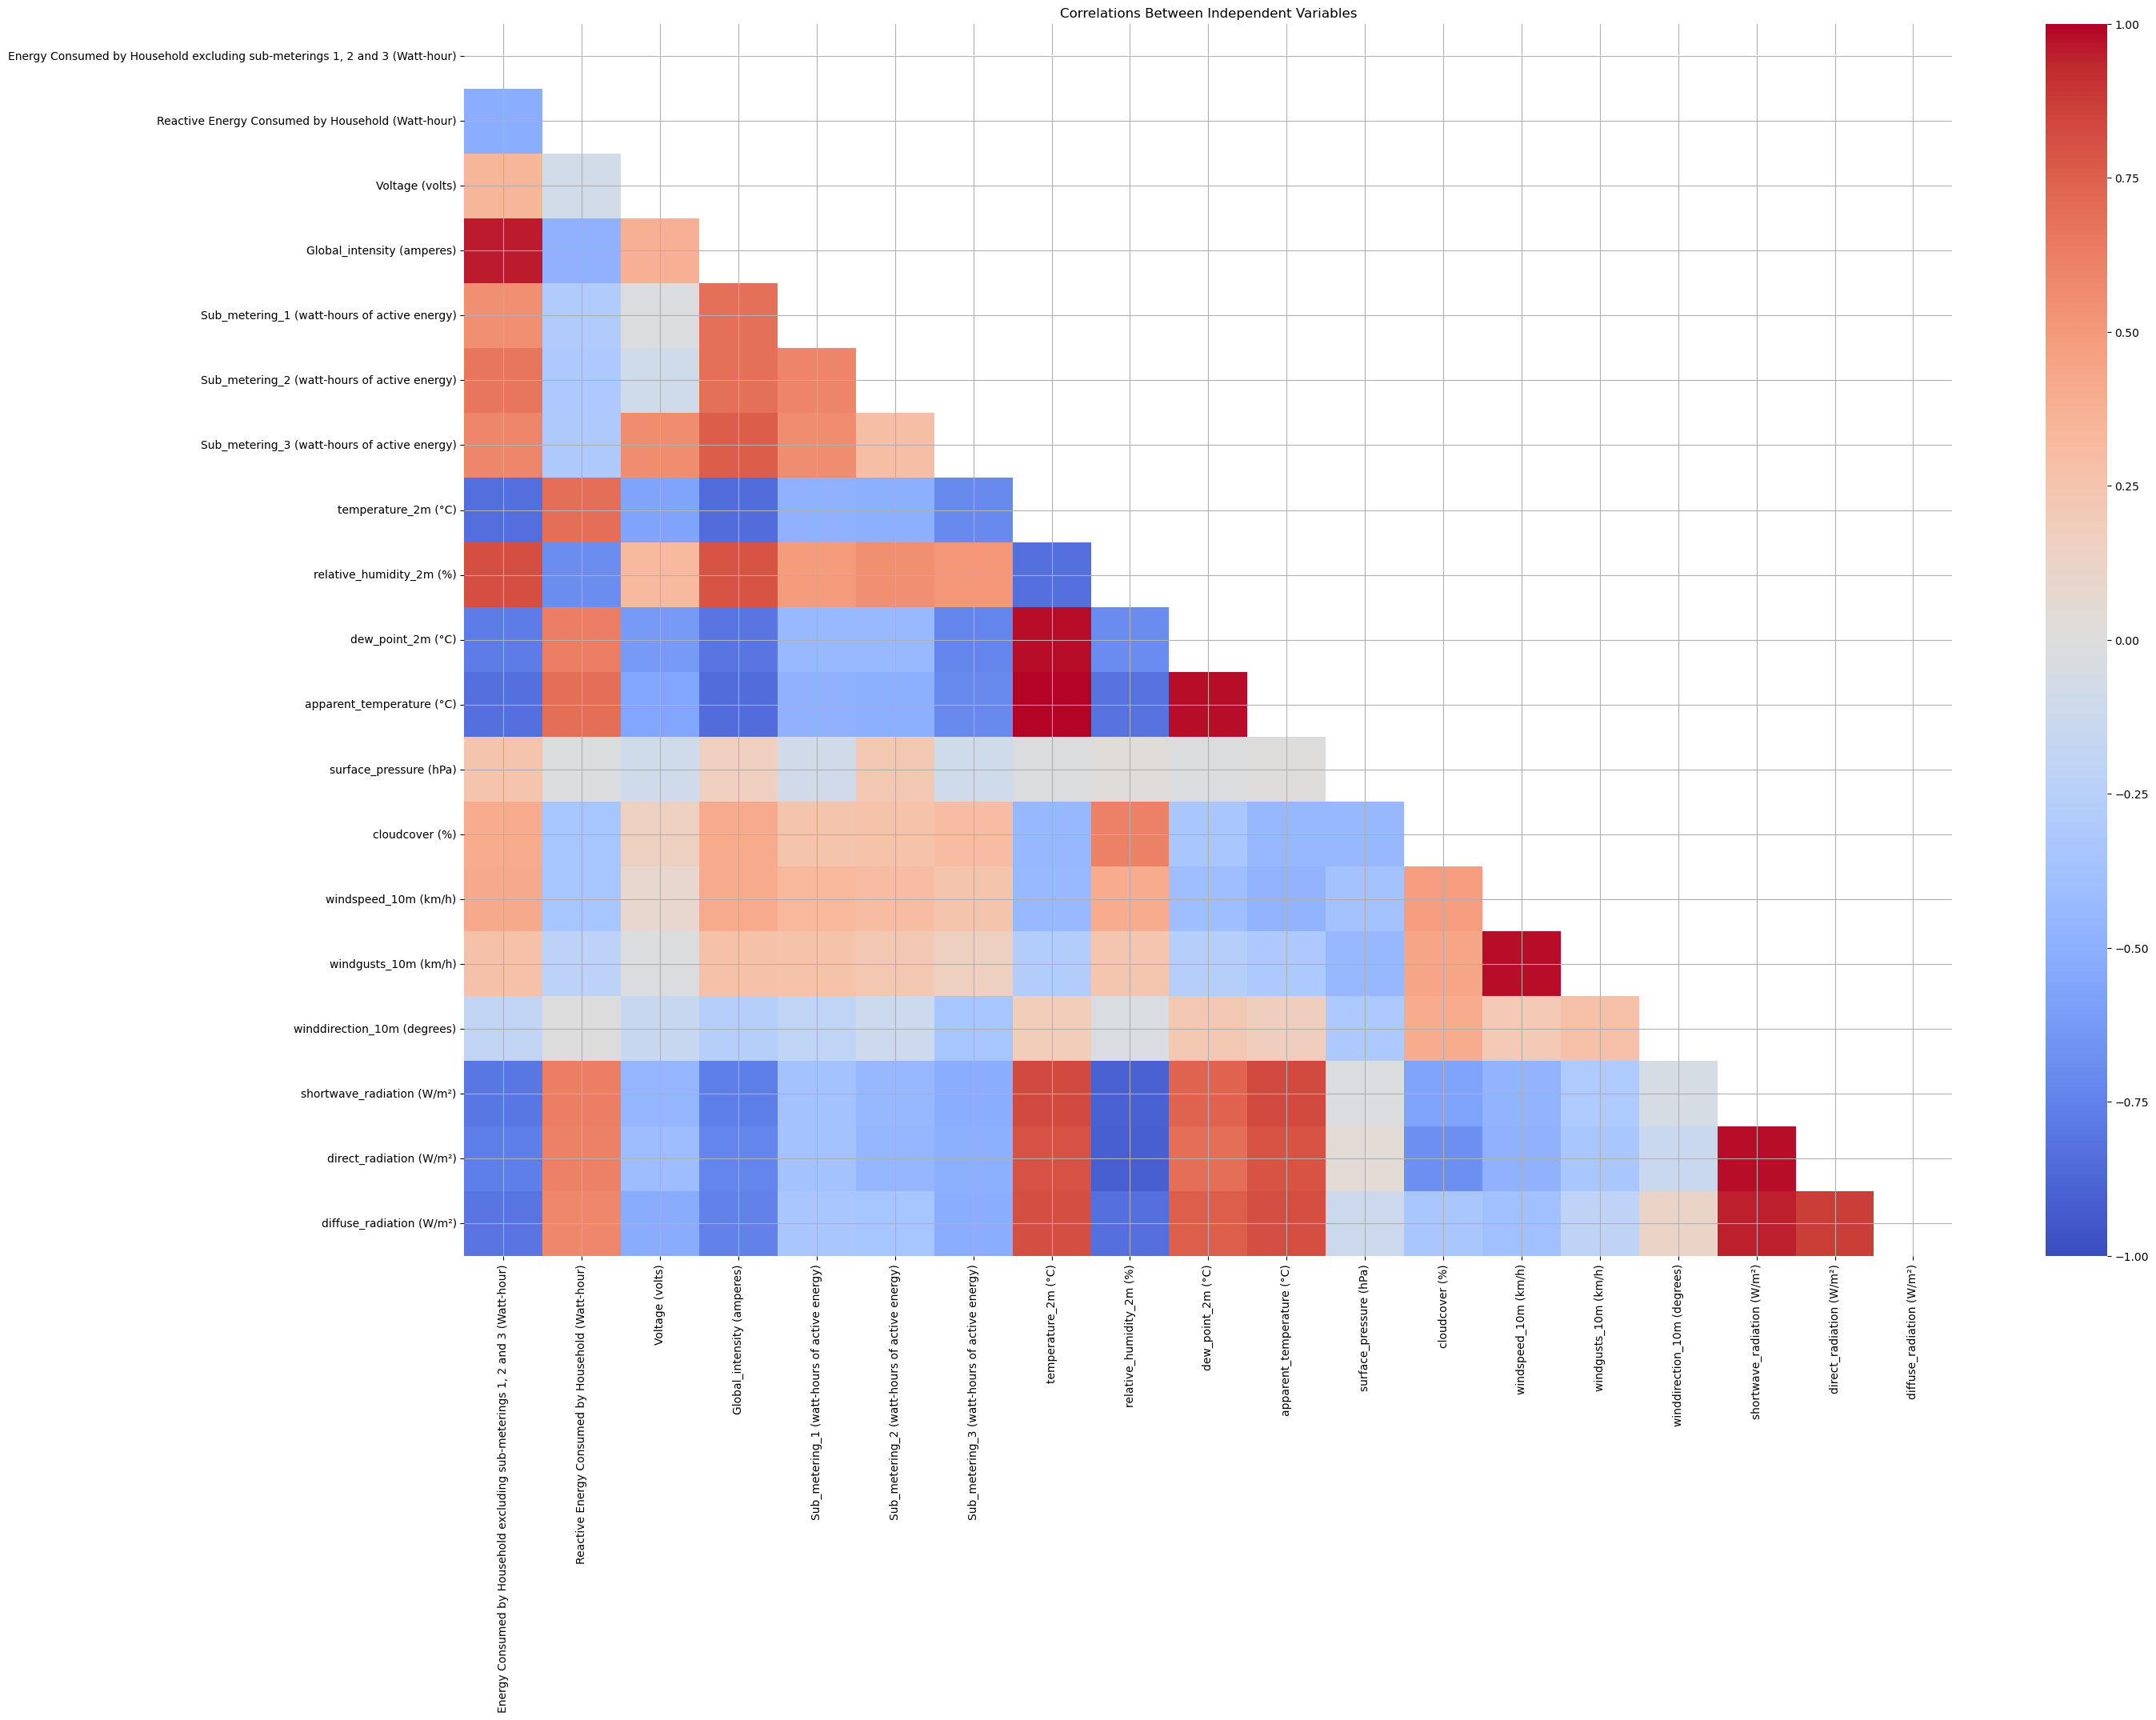

In [130]:
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(30, 20))
sns.heatmap(
    corr_df.round(2), 
    annot=True, 
    vmax=1, 
    vmin=-1, 
    center=0, 
    cmap="coolwarm", 
    mask=mask
)

plt.title("Correlations Between Independent Variables")
plt.show()

**Note: I dont why my correlation heatmap matrix is not showing any numeric values. I tried everything, so I use a table to see the actual values**

In [131]:
X.corr().round(2)

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",1.00,-0.51,0.35,0.96,0.55,0.66,0.59,-0.84,0.82,-0.78,-0.83,0.25,0.40,0.42,0.27,-0.19,-0.80,-0.76,-0.81
Reactive Energy Consumed by Household (Watt-hour),-0.51,1.00,-0.08,-0.48,-0.29,-0.32,-0.31,0.69,-0.69,0.63,0.69,-0.01,-0.35,-0.35,-0.22,-0.00,0.62,0.61,0.58
Voltage (volts),0.35,-0.08,1.00,0.38,-0.01,-0.10,0.56,-0.57,0.32,-0.62,-0.56,-0.10,0.15,0.08,-0.01,-0.15,-0.46,-0.41,-0.52
Global_intensity (amperes),0.96,-0.48,0.38,1.00,0.68,0.68,0.76,-0.85,0.79,-0.81,-0.85,0.16,0.41,0.41,0.27,-0.26,-0.76,-0.73,-0.75
Sub_metering_1 (watt-hours of active energy),0.55,-0.29,-0.01,0.68,1.00,0.60,0.56,-0.48,0.49,-0.43,-0.48,-0.09,0.25,0.33,0.26,-0.20,-0.37,-0.37,-0.33
Sub_metering_2 (watt-hours of active energy),0.66,-0.32,-0.10,0.68,0.60,1.00,0.29,-0.50,0.55,-0.43,-0.50,0.22,0.26,0.30,0.22,-0.11,-0.44,-0.46,-0.35
Sub_metering_3 (watt-hours of active energy),0.59,-0.31,0.56,0.76,0.56,0.29,1.00,-0.71,0.51,-0.73,-0.71,-0.10,0.31,0.25,0.15,-0.35,-0.51,-0.50,-0.51
temperature_2m (°C),-0.84,0.69,-0.57,-0.85,-0.48,-0.50,-0.71,1.00,-0.83,0.98,1.00,-0.01,-0.44,-0.43,-0.28,0.18,0.83,0.80,0.82
relative_humidity_2m (%),0.82,-0.69,0.32,0.79,0.49,0.55,0.51,-0.83,1.00,-0.70,-0.82,0.02,0.61,0.40,0.24,-0.03,-0.90,-0.91,-0.83
dew_point_2m (°C),-0.78,0.63,-0.62,-0.81,-0.43,-0.43,-0.73,0.98,-0.70,1.00,0.98,-0.01,-0.34,-0.40,-0.26,0.22,0.74,0.69,0.75


If two independent variables are highly correlated (|r| ≥ 0.9 or so), I will only  keep just one of them.

Strong correlations I notice from the map:


`Temperature-related variables`

**temperature_2m ↔ apparent_temperature (almost perfect correlation, r ≈ 1)**

**temperature_2m ↔ dew_point_2m (almost perfect correlation, r ≈ 1)**


I will be keeping temperature_2m and drop apparent_temperatur and dew_point_2m.

`Wind speed variables`

**windspeed_10m ↔ windgusts_10m (perfect correlation, r = 1)**

I will be keeping windspeed_10m,  but will drop windgusts_10m.

`Radiation variables`

**Shortwave_radiation ↔ direct_radiation (very high correlation)**

**Shortwave_radiation ↔ diffuse_radiation (high correlation)**

I will drop 2  radiation variables: direct and shortwave and keep diffuse

`Global_intensity (Current)`

**Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour) ↔ `Global_intensity** 

This essentially is highly corelated to Energy/Power as Power can be expressed as Voltage *Current (Intensity).

`Sub_metering variables`

Some correlations exist (e.g., Sub_metering_1 and Sub_metering_3 moderately correlated), but not as extreme — I will keep all of them as they are conceptually different.

Dropping variables for linear regression:

`apparent_temperature`

`dew_point_2m`

`windgusts_10m`

`direct_radiation` 

` shortwave_radiation`

`Global_intensity (amperes)`



In [132]:
X.columns

Index(['Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)',
       'Reactive Energy Consumed by Household (Watt-hour)', 'Voltage (volts)',
       'Global_intensity (amperes)',
       'Sub_metering_1 (watt-hours of active energy)',
       'Sub_metering_2 (watt-hours of active energy)',
       'Sub_metering_3 (watt-hours of active energy)', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'surface_pressure (hPa)', 'cloudcover (%)',
       'windspeed_10m (km/h)', 'windgusts_10m (km/h)',
       'winddirection_10m (degrees)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)'],
      dtype='object')

In [133]:
# Drop the identified columns
cols_to_drop = ["apparent_temperature (°C)", "dew_point_2m (°C)","windgusts_10m (km/h)", "direct_radiation (W/m²)", "shortwave_radiation (W/m²)",'Global_intensity (amperes)']
X.drop(cols_to_drop, axis=1, inplace=True)


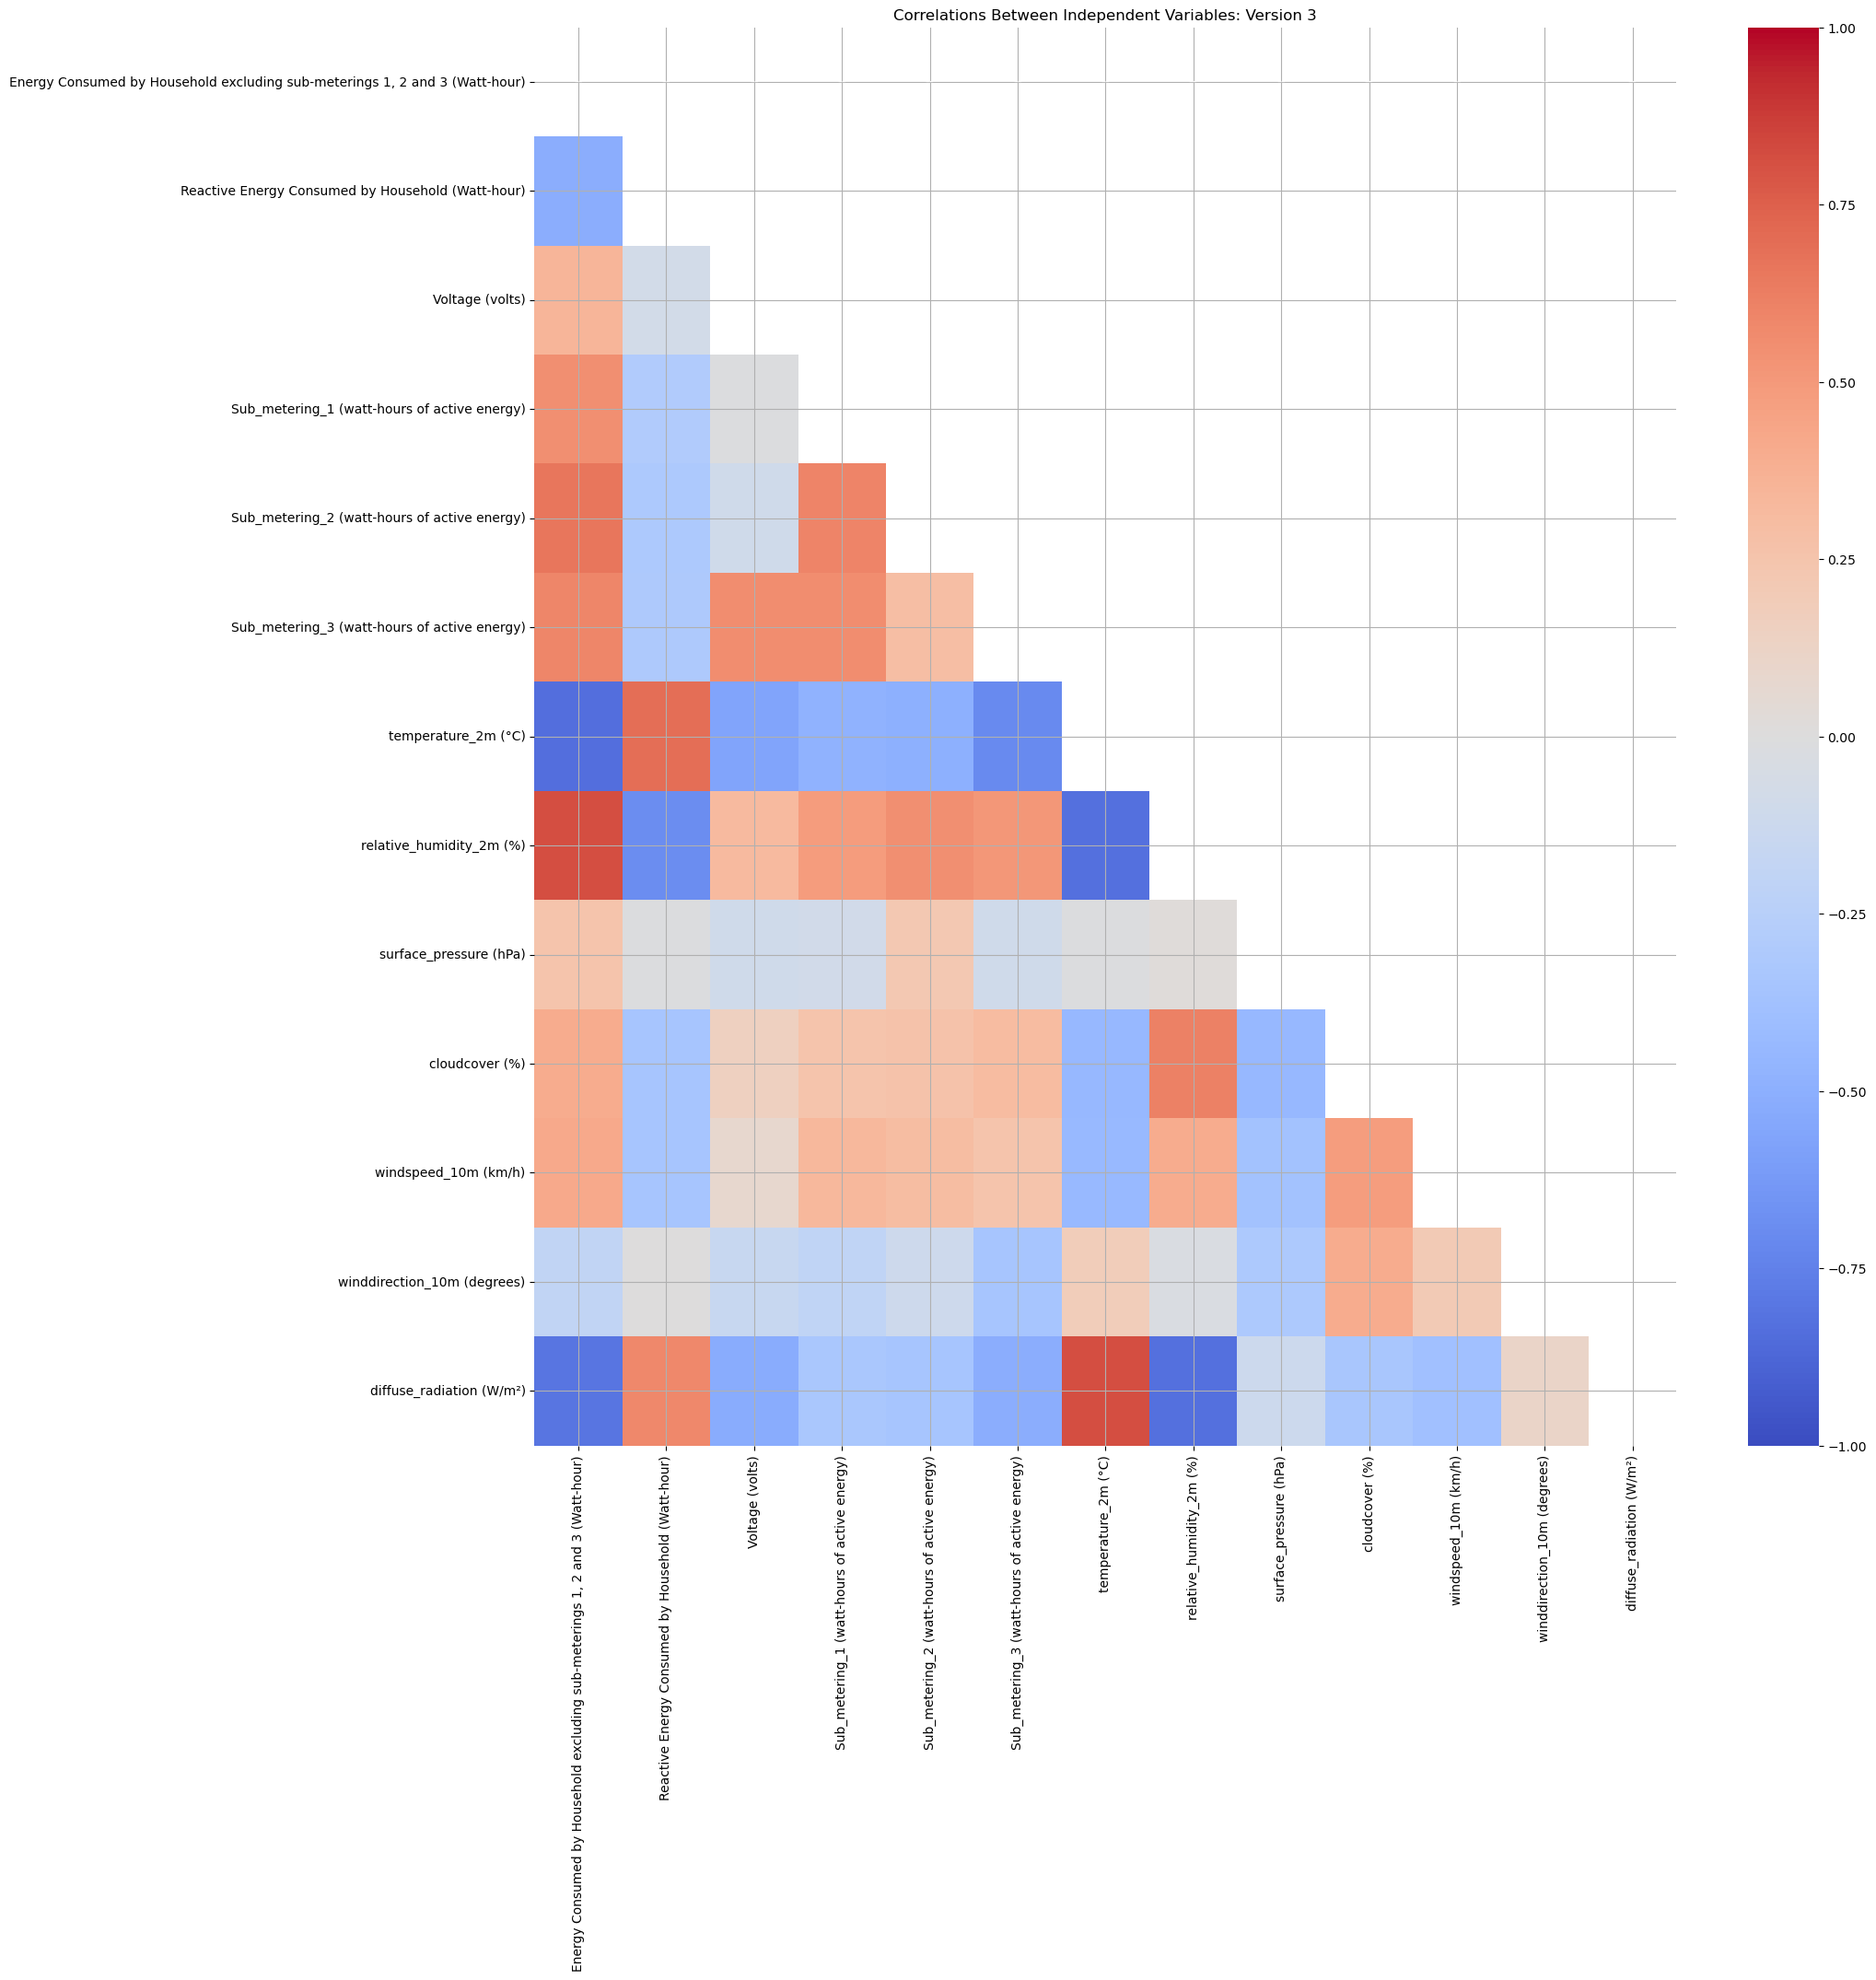

In [134]:
#checking the correlations again after dropping the columns
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_df.round(2), 
    annot=True, 
    vmax=1, 
    vmin=-1, 
    center=0, 
    cmap="coolwarm", 
    mask=mask
)

plt.title("Correlations Between Independent Variables: Version 3")
plt.show()

**Note: I dont why my correlation heatmap matrix is not showing any numeric values. I tried everything, so I use a table to see the actual values**

In [135]:
X.corr().round(2)

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (degrees),diffuse_radiation (W/m²)
"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",1.00,-0.51,0.35,0.55,0.66,0.59,-0.84,0.82,0.25,0.40,0.42,-0.19,-0.81
Reactive Energy Consumed by Household (Watt-hour),-0.51,1.00,-0.08,-0.29,-0.32,-0.31,0.69,-0.69,-0.01,-0.35,-0.35,-0.00,0.58
Voltage (volts),0.35,-0.08,1.00,-0.01,-0.10,0.56,-0.57,0.32,-0.10,0.15,0.08,-0.15,-0.52
Sub_metering_1 (watt-hours of active energy),0.55,-0.29,-0.01,1.00,0.60,0.56,-0.48,0.49,-0.09,0.25,0.33,-0.20,-0.33
Sub_metering_2 (watt-hours of active energy),0.66,-0.32,-0.10,0.60,1.00,0.29,-0.50,0.55,0.22,0.26,0.30,-0.11,-0.35
Sub_metering_3 (watt-hours of active energy),0.59,-0.31,0.56,0.56,0.29,1.00,-0.71,0.51,-0.10,0.31,0.25,-0.35,-0.51
temperature_2m (°C),-0.84,0.69,-0.57,-0.48,-0.50,-0.71,1.00,-0.83,-0.01,-0.44,-0.43,0.18,0.82
relative_humidity_2m (%),0.82,-0.69,0.32,0.49,0.55,0.51,-0.83,1.00,0.02,0.61,0.40,-0.03,-0.83
surface_pressure (hPa),0.25,-0.01,-0.10,-0.09,0.22,-0.10,-0.01,0.02,1.00,-0.44,-0.37,-0.32,-0.12
cloudcover (%),0.40,-0.35,0.15,0.25,0.26,0.31,-0.44,0.61,-0.44,1.00,0.48,0.40,-0.34


I will define the train and test sets based on the earlier defined dates_train and dates_test for daily data


In [136]:
# Create X_train and X_test from X using the same cutoff logic as before
X_train = X.loc[dates_train]
X_test = X.loc[dates_test]

In [137]:
X_test.head()

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),winddirection_10m (degrees),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,
2010-01-01,11.643089,2.086323,243.455510,1.298200,1.362789,9.538004,0.377776,85.044783,1004.682451,76.546685,11.114993,173.977681,22.802967
2010-02-01,10.168075,1.707351,242.348111,1.221985,1.329183,10.211667,3.371565,80.471206,993.288873,79.196160,15.988025,167.217636,39.263852
2010-03-01,8.971096,2.084247,241.993211,0.823434,1.428484,7.611574,6.090126,71.280681,1006.384237,67.692430,14.867392,167.933579,61.269888
2010-04-01,7.612963,2.080848,241.782798,0.884187,0.844371,7.780064,10.259553,68.717643,1007.753289,52.417401,13.068780,136.224137,69.062972
2010-05-01,7.835420,2.036416,240.369171,1.077690,1.173324,8.168306,12.391949,68.148107,1004.779938,64.297257,12.874001,168.308419,90.424834


In [138]:
y_train = y.loc[dates_train].dropna()
y_test = y.loc[dates_test].dropna()

In [139]:
# Fit
linreg_features = LinearRegression()
linreg_features.fit(X_train, y_train)

# Predict
linreg_features_pred_train = linreg_features.predict(X_train)
linreg_features_pred_test = linreg_features.predict(X_test)

In [140]:
# Evaluate

summary_df.loc['linreg_features'] = [
    mean_absolute_error(y_train, linreg_features_pred_train),
    mean_absolute_error(y_test, linreg_features_pred_test),
    mean_absolute_percentage_error(y_train, linreg_features_pred_train),
    mean_absolute_percentage_error(y_test, linreg_features_pred_test)
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347e+00,3.101882e+00,2.922166e-01,2.158319e-01
linreg,4.077902e+00,3.336767e+00,2.946289e-01,2.017694e-01
linreg_ohe,1.315639e+00,1.717609e+00,9.581909e-02,1.047659e-01
linreg_features,2.021206e-14,1.986290e-14,1.224942e-15,1.145575e-15


In [141]:
# Original time series
#Plotting the model performance
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=power_df_monthly.index,
    y=power_df_monthly['Energy Consumed by Household (Watt-hour)'],
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train,
    y=linreg_features_pred_train,
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=linreg_features_pred_test,
    mode='lines',
    name='test',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title='Linear Regression with DataSet Features Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Date',
    legend_title='Legend'
)

fig.show()

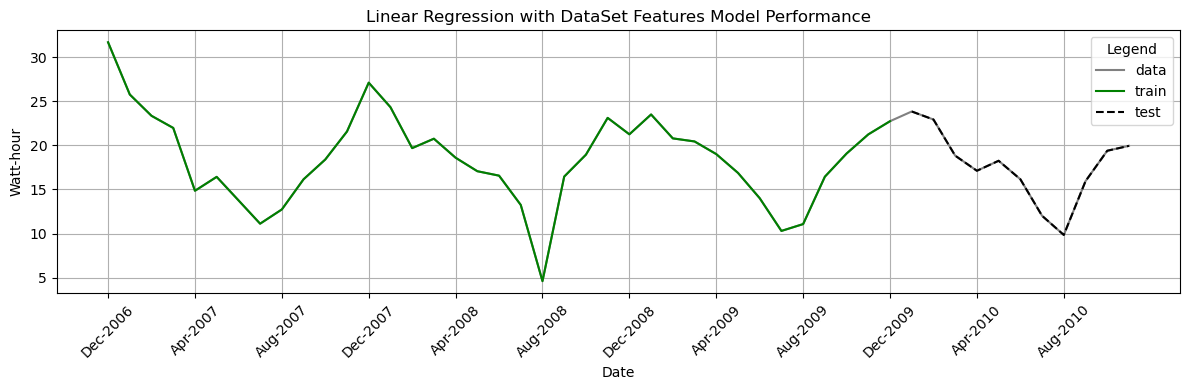

In [142]:
#Plotting the model performance
plt.figure(figsize=(12, 4))

# Original time series
plt.plot(power_df_monthly.index, power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label='data')

# Train predictions
plt.plot(dates_train, linreg_features_pred_train, color='green', label='train')

# Test predictions
plt.plot(dates_test, linreg_features_pred_test, color='black', linestyle='--', label='test')

plt.title('Linear Regression with DataSet Features Model Performance')
plt.ylabel('Watt-hour')
plt.xlabel('Date')
plt.legend(title='Legend')

# Format x-axis as month-year and reduce number of ticks
labels = pd.to_datetime(power_df_monthly.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
plt.xticks(ticks=range(0, len(labels), step), labels=labels[::step], rotation=45)

plt.tight_layout()
plt.show()


In [143]:
summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347e+00,3.101882e+00,2.922166e-01,2.158319e-01
linreg,4.077902e+00,3.336767e+00,2.946289e-01,2.017694e-01
linreg_ohe,1.315639e+00,1.717609e+00,9.581909e-02,1.047659e-01
linreg_features,2.021206e-14,1.986290e-14,1.224942e-15,1.145575e-15


The summary_df now contains the performance metrics for all models, including the mean model, linear regression, linear regression with one-hot encoding, and linear regression with dataset features.

The linreg_features model does show a very significant improvement in performance metrics, especially in the test set, indicating that the additional features have helped the model generalize better to unseen data, however this might also be due to the features that represent this model, I will come back to this later

#  Forecasting with ARIMA Model

Next I will be looking at the ARIMA models for forecasting the energy consumption.


Let's starting by building a simple ARIMA model that includes an AR term of 1 (ie. to predict each value we will use the last 1 month). To pick the optimal values of p, d and q I will later use Grid Search CV for Sprint 2:

Unoptimized ARIMA
As discussed in the section above, we will now also introduce an MA term to factor in previous forecasting errors. To pick the optimal values of p, d and q we will use grid search:

In [144]:
# Fit
arima_311 = SARIMAX(y_train, order=(3, 1, 1)).fit(disp=0)

# Predict
arima_311_pred_train = arima_311.predict(dates_train.min(), dates_train.max())
arima_311_pred_test = arima_311.predict(dates_test.min(), dates_test.max())

In [145]:
# Evaluate

summary_df.loc['arima_311'] = [
    mean_absolute_error(y_train, arima_111_pred_train),
    mean_absolute_error(y_test, arima_111_pred_test),
    mean_absolute_percentage_error(y_train, arima_111_pred_train),
    mean_absolute_percentage_error(y_test, arima_111_pred_test)
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
Mean,4.034347e+00,3.101882e+00,2.922166e-01,2.158319e-01
linreg,4.077902e+00,3.336767e+00,2.946289e-01,2.017694e-01
linreg_ohe,1.315639e+00,1.717609e+00,9.581909e-02,1.047659e-01
linreg_features,2.021206e-14,1.986290e-14,1.224942e-15,1.145575e-15
arima_311,3.826463e+00,5.577666e+00,2.330022e-01,3.979674e-01


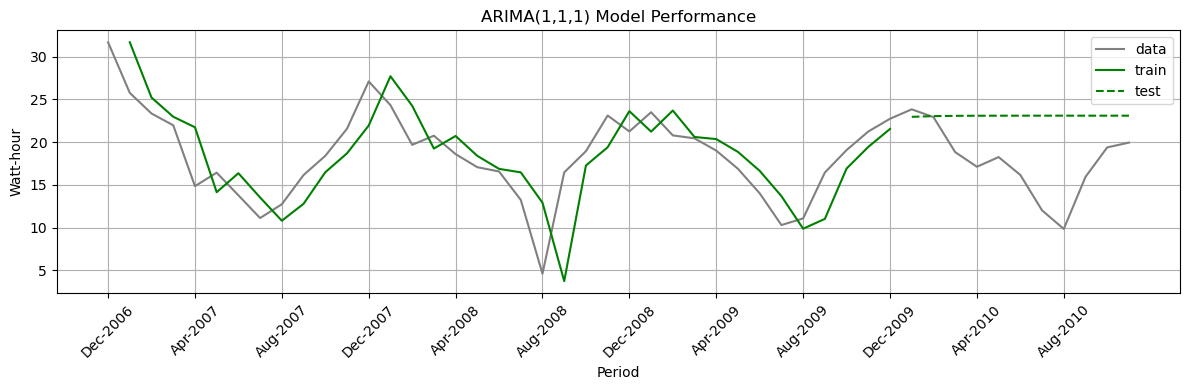

In [156]:
plt.figure()
# Original time series
plt.plot(y.index, y.values, color='grey', label="data")

# Train and test predictions
plt.plot(dates_train[1:], arima_111_pred_train[1:], color='green', label="train")
plt.plot(dates_test, arima_111_pred_test, color='green', ls="--", label="test")

plt.ylabel("Watt-hour")
plt.xlabel("Period")
plt.title(f"ARIMA(1,1,1) Model Performance")
plt.legend()

# Format x-axis as month-year and reduce number of ticks
labels = pd.to_datetime(y.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
plt.xticks(ticks=range(0, len(labels), step), labels=labels[::step], rotation=45)

plt.tight_layout()
plt.show()

In [154]:
import plotly.graph_objs as go

fig = go.Figure()

# Original time series
fig.add_trace(go.Scatter(
    x=y.index,
    y=y.values,
    mode='lines',
    name='data',
    line=dict(color='grey')
))

# Train predictions
fig.add_trace(go.Scatter(
    x=dates_train[1:],
    y=arima_111_pred_train[1:],
    mode='lines',
    name='train',
    line=dict(color='green')
))

# Test predictions
fig.add_trace(go.Scatter(
    x=dates_test,
    y=arima_111_pred_test,
    mode='lines',
    name='test',
    line=dict(color='green', dash='dash')
))

# Format x-axis as month-year and reduce number of ticks
labels = pd.to_datetime(y.index).strftime('%b-%Y')
step = max(1, len(labels) // 10)
fig.update_layout(
    title='ARIMA(1,1,1) Model Performance',
    yaxis_title='Watt-hour',
    xaxis_title='Period',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=y.index[::step],
        ticktext=labels[::step],
        tickangle=45
    ),
    width=900,
    height=400
)

fig.show()

# Next Steps: Sprint 3

Optimize the ARIMA model through Hyper Parameter Tunning

Look at XGBoost  and Facebook's Prophet time series forecasting tool- to comple modelling step

Look into some Deep Learning models like LSTM, given the time available or for future developments
